In [0]:
import numpy as np
import pandas as pd
from skimage.io import imread, imshow
#!pip install periodictable
import periodictable
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from pathlib import Path
import re
import json

In [2]:
samples_df = pd.read_csv('simulated_mineral_samples.csv')
samples_df.head()

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral
0,0,0,0,268,69,0,4,Millerite
1,0,0,0,109,74,0,4,Millerite
2,0,1,0,159,78,0,2,Millerite
3,0,0,0,323,76,0,3,Millerite
4,0,1,0,240,72,0,4,Millerite


In [0]:
X = samples_df[['Ca', 'Fe', 'Mg', 'Ni', 'S', 'Si', 'Ti']].values
Y = samples_df['mineral']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

In [4]:
#mod = SVC(kernel='rbf', max_iter=300)
mod = RandomForestClassifier(100, max_depth=5, n_jobs=-1)
mod.fit(X_train, Y_train)
(mod.predict(X_train) == Y_train).mean(), (mod.predict(X_test) == Y_test).mean()

(0.9525, 0.9547857142857142)

In [5]:
np.argmax(mod.predict_proba(X_test[:5]), axis=1)

array([0, 6, 4, 2, 5])

In [0]:
# Define where your images are

root = Path('gdrive/My Drive/meteorite_mineral_mapper')
image_path = root / 'dataset_1_opaques'

In [41]:
#standard_minerals = [i for i in list(image_path.glob('*_mask.tif')) if 'obj' not in i.name]
#standards = [{'name': s.name.split('_')[2].split('.')[0], 'image': imread(s)} for s in image_path.glob('standards_32*.tif')]

images = [{'element': s.name.split('_')[2].split('.')[0], 'image': imread(s)} for s in image_path.glob('obj1_32bt_*')]
images

[{'element': 'Al', 'image': array([[25, 45, 51, ...,  8,  7,  5],
         [15, 19, 47, ...,  5, 11, 11],
         [ 8,  8, 18, ...,  7, 15,  8],
         ...,
         [ 0,  0,  5, ...,  0,  0,  0],
         [ 2,  3,  2, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  4]], dtype=int32)},
 {'element': 'Ca', 'image': array([[26, 15, 11, ...,  2,  6,  0],
         [37, 29, 21, ...,  5,  0,  0],
         [46, 45, 29, ...,  3,  7,  6],
         ...,
         [ 9, 13, 11, ...,  0,  2,  0],
         [ 4,  3,  3, ...,  2,  0,  2],
         [ 2,  0,  4, ...,  0,  0,  0]], dtype=int32)},
 {'element': 'Cr', 'image': array([[25, 17, 12, ..., 11,  9,  9],
         [15, 15, 10, ...,  3,  4,  9],
         [23, 20, 14, ...,  7,  8, 11],
         ...,
         [10,  6, 25, ...,  3,  7,  2],
         [10,  6, 11, ...,  5,  7, 10],
         [11,  9,  7, ...,  2,  4,  6]], dtype=int32)},
 {'element': 'Fe', 'image': array([[ 15,  12,   9, ...,  75,  81,  83],
         [  6,   7,  11, ...,  82,  72, 

In [0]:
columns = []
pixels = []
for element in images:
  columns.append(element['element'])
  pixels.append(element['image'].flatten())

In [43]:
image_pixels_df = pd.DataFrame(np.dstack(pixels)[0], columns=columns)
image_pixels_df = image_pixels_df.reset_index().rename(columns={'Pho': 'P', 'Sul': 'S', 'index': 'order'})
image_pixels_df.head()

,order,Al,Ca,Cr,Fe,Mg,Ni,P,Si,S,Ti
0,0,25,26,25,15,65,0,0,332,0,9
1,1,45,15,17,12,26,0,0,229,0,12
2,2,51,11,12,9,5,0,0,262,0,8
3,3,62,5,12,8,5,0,5,278,0,12
4,4,80,4,6,5,6,0,0,313,0,9


In [0]:
X = image_pixels_df[['Ca', 'Fe', 'Mg', 'Ni', 'S', 'Si', 'Ti']].values
image_pixels_df['predicted_element'] = mod.predict(X)

In [45]:

results = image_pixels_df.merge(
    pd.Series(mod.classes_, name='predicted_element').reset_index().rename(columns={'index': 'element_index'}),
    on='predicted_element'
).sort_values('order')
results.head()

,order,Al,Ca,Cr,Fe,Mg,Ni,P,Si,S,Ti,predicted_element,element_index
0,0,25,26,25,15,65,0,0,332,0,9,Pyroxene,4
1,1,45,15,17,12,26,0,0,229,0,12,Pyroxene,4
2,2,51,11,12,9,5,0,0,262,0,8,Pyroxene,4
3,3,62,5,12,8,5,0,5,278,0,12,Pyroxene,4
4,4,80,4,6,5,6,0,0,313,0,9,Pyroxene,4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


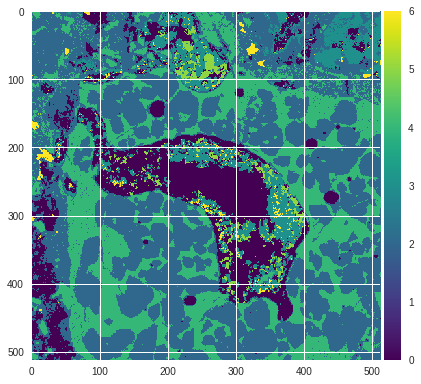

In [46]:
imshow(results['element_index'].reshape((512, 512)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


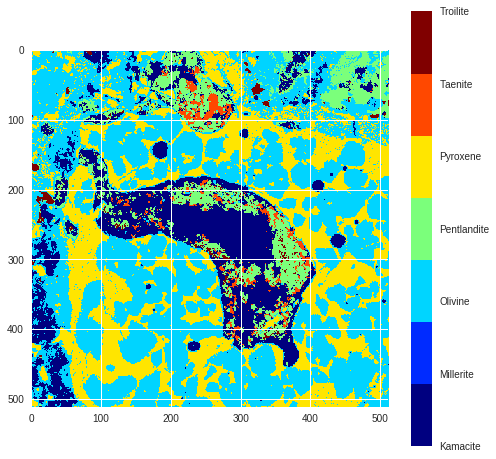

In [47]:
figure, ax = plt.subplots(figsize=(8,8))
i = ax.imshow(
    results['element_index'].reshape((512, 512)),
    cmap=plt.cm.get_cmap('jet', len(mod.classes_))
)
cbar = figure.colorbar(i, ticks=range(len(mod.classes_)))
cbar.ax.set_yticklabels(mod.classes_)
ax.legend()

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


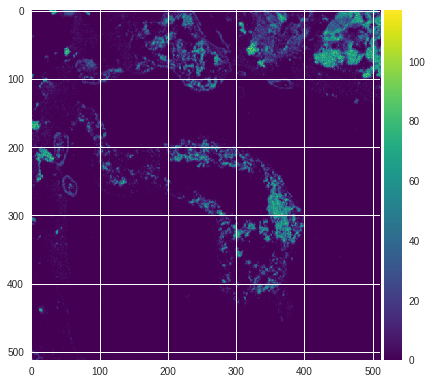

In [49]:
imshow(images[-2]['image'])

array(['Kamacite', 'Millerite', 'Olivine', 'Pentlandite', 'Pyroxene',
       'Taenite', 'Troilite'], dtype=object)

In [0]:
#results['predicted_element'].reshape((512, 512)).tolist()

In [34]:
results.groupby('predicted_element').count()

,order,Al,Ca,Cr,Fe,Mg,Ni,P,S,Si,Ti,element_index
predicted_element,,,,,,,,,,,,
Kamacite,76555,76555,76555,76555,76555,76555,76555,76555,76555,76555,76555,76555
Olivine,82449,82449,82449,82449,82449,82449,82449,82449,82449,82449,82449,82449
Pentlandite,34408,34408,34408,34408,34408,34408,34408,34408,34408,34408,34408,34408
Pyroxene,33497,33497,33497,33497,33497,33497,33497,33497,33497,33497,33497,33497
Taenite,12810,12810,12810,12810,12810,12810,12810,12810,12810,12810,12810,12810
Troilite,22425,22425,22425,22425,22425,22425,22425,22425,22425,22425,22425,22425


In [35]:
import json
with open('obj2_array.json', 'w') as outfile:
    json.dump(results['predicted_element'].reshape((512, 512)).tolist(), outfile)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
!ls

gdrive		 obj2_array.json  simulated_mineral_samples.csv
obj1_array.json  sample_data


In [0]:
!cp obj* gdrive/My\ Drive

In [0]:
probas = mod.predict_proba(X)

In [51]:
probas[0]

array([1.31707528e-03, 0.00000000e+00, 1.25773997e-01, 1.14575968e-04,
       8.72546520e-01, 2.39830218e-04, 8.00142248e-06])

In [52]:
mod.classes_

array(['Kamacite', 'Millerite', 'Olivine', 'Pentlandite', 'Pyroxene',
       'Taenite', 'Troilite'], dtype=object)

In [0]:
results2 = image_pixels_df.copy()
#results2[mod.classes_] = probas
results2 = pd.concat([results2, pd.DataFrame(probas, columns=mod.classes_)], axis=1)

In [62]:
results2.groupby('predicted_element').mean()[mod.classes_]

,Kamacite,Millerite,Olivine,Pentlandite,Pyroxene,Taenite,Troilite
predicted_element,,,,,,,
Kamacite,0.602850,0.003063,0.047418,0.038084,0.014519,0.258972,0.035095
Olivine,0.020487,0.001034,0.773114,0.021249,0.168984,0.010852,0.004280
Pentlandite,0.082542,0.060294,0.058580,0.634787,0.012447,0.069144,0.082207
Pyroxene,0.008710,0.000088,0.155630,0.002029,0.828035,0.004717,0.000792
Taenite,0.261830,0.004440,0.024257,0.075887,0.005440,0.615619,0.012528
Troilite,0.110592,0.025210,0.055405,0.220326,0.012928,0.020925,0.554614


In [65]:
results2['max_probab'] = results2[mod.classes_].max(axis=1)
results2.head()

,order,Al,Ca,Cr,Fe,Mg,Ni,P,Si,S,Ti,predicted_element,Kamacite,Millerite,Olivine,Pentlandite,Pyroxene,Taenite,Troilite,max_probab
0,0,25,26,25,15,65,0,0,332,0,9,Pyroxene,0.001317,0.0,0.125774,0.000115,0.872547,0.000240,0.000008,0.872547
1,1,45,15,17,12,26,0,0,229,0,12,Pyroxene,0.000622,0.0,0.157899,0.000055,0.841216,0.000209,0.000000,0.841216
2,2,51,11,12,9,5,0,0,262,0,8,Pyroxene,0.001317,0.0,0.125824,0.000115,0.872496,0.000240,0.000008,0.872496
3,3,62,5,12,8,5,0,5,278,0,12,Pyroxene,0.000622,0.0,0.157899,0.000055,0.841216,0.000209,0.000000,0.841216
4,4,80,4,6,5,6,0,0,313,0,9,Pyroxene,0.001317,0.0,0.125774,0.000115,0.872547,0.000240,0.000008,0.872547


In [71]:
results2[results2['max_probab'] < .5].groupby('predicted_element').count()['order'] / results2.groupby('predicted_element').count()['order']

predicted_element
Kamacite       0.160575
Olivine        0.071797
Pentlandite    0.113486
Pyroxene       0.006448
Taenite        0.174950
Troilite       0.512505
Name: order, dtype: float64

In [72]:
results2[results2['max_probab'] < .5].groupby('predicted_element').count()['order'] 

predicted_element
Kamacite       6524
Olivine        8912
Pentlandite    2650
Pyroxene        433
Taenite         792
Troilite       1209
Name: order, dtype: int64

In [85]:
np.argsort(probas, axis=1)[:,-1][:10]

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [89]:
image_pixels_df.merge(
    pd.Series(mod.classes_, name='predicted_element_0').reset_index().rename(columns={'index': 'arg0'}),
    on='arg0'
).merge(
    pd.Series(mod.classes_, name='predicted_element_1').reset_index().rename(columns={'index': 'arg1'}),
    on='arg1'
).merge(
    pd.Series(mod.classes_, name='predicted_element_2').reset_index().rename(columns={'index': 'arg2'}),
    on='arg2'
)

,order,Al,Ca,Cr,Fe,Mg,Ni,P,Si,S,Ti,predicted_element,arg0,arg1,arg2,predicted_element_0,predicted_element_1,predicted_element_2
0,0,25,26,25,15,65,0,0,332,0,9,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
1,1,45,15,17,12,26,0,0,229,0,12,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
2,2,51,11,12,9,5,0,0,262,0,8,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
3,3,62,5,12,8,5,0,5,278,0,12,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
4,4,80,4,6,5,6,0,0,313,0,9,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
5,5,75,4,6,7,7,3,3,312,0,6,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
6,6,73,6,4,5,22,0,0,302,0,5,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
7,7,49,0,0,12,37,0,0,324,0,7,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
8,8,44,3,0,10,78,0,2,328,0,4,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
9,9,23,5,10,17,120,0,0,270,0,5,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite


In [90]:
image_pixels_df['arg0'] = np.argsort(probas, axis=1)[:,-1]
image_pixels_df['arg1'] = np.argsort(probas, axis=1)[:,-2]
image_pixels_df['arg2'] = np.argsort(probas, axis=1)[:,-3]

image_pixels_df = image_pixels_df.merge(
    pd.Series(mod.classes_, name='predicted_element_0').reset_index().rename(columns={'index': 'arg0'}),
    on='arg0'
).merge(
    pd.Series(mod.classes_, name='predicted_element_1').reset_index().rename(columns={'index': 'arg1'}),
    on='arg1'
).merge(
    pd.Series(mod.classes_, name='predicted_element_2').reset_index().rename(columns={'index': 'arg2'}),
    on='arg2'
)

image_pixels_df

,order,Al,Ca,Cr,Fe,Mg,Ni,P,Si,S,Ti,predicted_element,arg0,arg1,arg2,predicted_element_0,predicted_element_1,predicted_element_2
0,0,25,26,25,15,65,0,0,332,0,9,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
1,1,45,15,17,12,26,0,0,229,0,12,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
2,2,51,11,12,9,5,0,0,262,0,8,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
3,3,62,5,12,8,5,0,5,278,0,12,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
4,4,80,4,6,5,6,0,0,313,0,9,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
5,5,75,4,6,7,7,3,3,312,0,6,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
6,6,73,6,4,5,22,0,0,302,0,5,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
7,7,49,0,0,12,37,0,0,324,0,7,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
8,8,44,3,0,10,78,0,2,328,0,4,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite
9,9,23,5,10,17,120,0,0,270,0,5,Pyroxene,4,2,0,Pyroxene,Olivine,Kamacite


In [0]:
results2['max_probab'] = results2[mod.classes_].max(axis=1)

In [92]:
image_pixels_df.groupby(['predicted_element_0', 'predicted_element_1']).count()

order      Al      Ca      Cr  \
predicted_element_0 predicted_element_1                                   
Kamacite            Olivine                5279    5279    5279    5279   
                    Pentlandite               1       1       1       1   
                    Taenite               35248   35248   35248   35248   
                    Troilite                101     101     101     101   
Olivine             Kamacite               3804    3804    3804    3804   
                    Pentlandite            7049    7049    7049    7049   
                    Pyroxene             113122  113122  113122  113122   
                    Taenite                  90      90      90      90   
                    Troilite                 62      62      62      62   
Pentlandite         Kamacite               8465    8465    8465    8465   
                    Millerite              1663    1663    1663    1663   
                    Olivine                5831    5831    5831    5831   
                    Pyroxene                 48      48      48      48   
                    Taenite                3234    3234    3234    3234   
                    Troilite               4110    4110    4110    4110   
Pyroxene            Kamacite               1698    1698    1698    1698   
                    Olivine               65288   65288   65288   65288   
                    Pentlandite             151     151     151     151   
                    Taenite                  13      13      13      13   
                    Troilite                  1       1       1       1   
Taenite             Kamacite               4187    4187    4187    4187   
                    Olivine                 340     340     340     340   
Troilite            Kamacite                 90      90      90      90   
                    Millerite                 6       6       6       6   
                    Olivine                 336     336     336     336   
                    Pentlandite            1927    1927    1927    1927   

                                             Fe      Mg      Ni       P  \
predicted_element_0 predicted_element_1                                   
Kamacite            Olivine                5279    5279    5279    5279   
                    Pentlandite               1       1       1       1   
                    Taenite               35248   35248   35248   35248   
                    Troilite                101     101     101     101   
Olivine             Kamacite               3804    3804    3804    3804   
                    Pentlandite            7049    7049    7049    7049   
                    Pyroxene             113122  113122  113122  113122   
                    Taenite                  90      90      90      90   
                    Troilite                 62      62      62      62   
Pentlandite         Kamacite               8465    8465    8465    8465   
                    Millerite              1663    1663    1663    1663   
                    Olivine                5831    5831    5831    5831   
                    Pyroxene                 48      48      48      48   
                    Taenite                3234    3234    3234    3234   
                    Troilite               4110    4110    4110    4110   
Pyroxene            Kamacite               1698    1698    1698    1698   
                    Olivine               65288   65288   65288   65288   
                    Pentlandite             151     151     151     151   
                    Taenite                  13      13      13      13   
                    Troilite                  1       1       1       1   
Taenite             Kamacite               4187    4187    4187    4187   
                    Olivine                 340     340     340     340   
Troilite            Kamacite                 90      90      90      90   
                    Millerite                 6       6       6   